In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models

2024-04-28 14:20:24.945729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 14:20:26.183771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
import time
import pickle
import json

In [ ]:
# many more here - https://archive.ics.uci.edu/

# iris dataset - very small (150 records)
# flower classification dataset

# for external dataset - leave one out class
# ds = tfds.load('iris', split='train', shuffle_files=True, as_supervised=True)
# ood_class = np.random.randint(0, 3)
# allY, allX = np.array([y for x, y in ds]), np.array([x for x, y in ds])
# binY = label_binarize(np.array(allY), classes=[0, 1, 2])
# dataY, dataX = binY[allY!=ood_class], allX[allY!=ood_class]
# dataX, dataX_tst, dataY, dataY_tst = train_test_split(dataX, dataY, test_size=0.10, random_state=42)

# external_Y, external_X = binY[allY==ood_class], allX[allY==ood_class]
# print(dataX.shape, dataX_tst.shape, dataY.shape, dataY_tst.shape)

In [ ]:
# # Shuttle datsaset - large (58k records)
# # class 1 consumes 80% dataset hence can be inlier dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/shuttle/shuttle.tst"
# df = pd.read_csv(url, header=None, delimiter=' ')
# df = df.loc[df[9] != 4]

# y = label_binarize(np.array(df[9]), classes=[1,2,3,5,6,7])
# not_ood_class = 1

# dataY, dataX = y[np.array(df[9])==not_ood_class], df[df[9]==not_ood_class].iloc[:,0:8]
# dataX, dataX_tst, dataY, dataY_tst = train_test_split(dataX, dataY, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# dataX = scaler.fit_transform(dataX)
# dataX_tst = scaler.transform(dataX_tst)

# external_Y, external_X = y[np.array(df[9])!=not_ood_class], df[df[9]!=not_ood_class].iloc[:,0:8]
# external_X = scaler.transform(external_X)
# print(dataX.shape, dataX_tst.shape, dataY.shape, dataY_tst.shape)

(8034, 8) (3444, 8) (8034, 6) (3444, 6)


In [17]:
# Gas sensor datsaset - medium (13k records)
# data drift detection + classification task
gas_data = pd.concat([pd.read_csv(f'./datasets-ood/Dataset/batch{i+1}.dat', sep=' ', header=None) for i in range(10)])

def transform(r):
    d = []
    d.append(r[0])
    for e in r[1:]:
        d.append(e[e.find(':') +1:])
    return pd.Series(data=d, index=r.index)

df = gas_data.apply(transform, axis=1)
feature_data = df[np.arange(1,129)]
scaler = StandardScaler().fit(feature_data) # should we use a different scaler for id and ood data?
scaled_feature_data = scaler.transform(feature_data)
target_data = df[np.array(0)]
binY = label_binarize(np.array(target_data), classes=[1, 2, 3, 4, 5, 6])

ood_class = np.random.randint(0, 6)+1
dataY, dataX = binY[target_data!=ood_class], scaled_feature_data[target_data!=ood_class]
dataX, dataX_tst, dataY, dataY_tst = train_test_split(dataX, dataY, test_size=0.10, random_state=42)

external_Y, external_X = binY[target_data==ood_class], scaled_feature_data[target_data==ood_class]

print(dataX.shape, dataX_tst.shape, dataY.shape, dataY_tst.shape)

(10869, 128) (1208, 128) (10869, 6) (1208, 6)


In [ ]:
# # Drive Diagnosis datsaset - large (58k records)
# dataset = pd.read_csv('/content/drive/My Drive/datasets-ood/Sensorless_drive_diagnosis.txt', sep=" ", header=None,names=[i for i in range(48)]+["label"])
# y = label_binarize(np.array(dataset["label"]), classes=[1, 2,3,4,5,6,7,8,9,10,11])
# ood_class = np.random.randint(0, 11)+1

# dataY, dataX = y[np.array(dataset["label"])!=ood_class], dataset[dataset["label"]!=ood_class].iloc[:,0:48]
# dataX, dataX_tst, dataY, dataY_tst = train_test_split(dataX, dataY, test_size=0.3, random_state=42)
# scaler = StandardScaler()
# dataX = scaler.fit_transform(dataX)
# dataX_tst = scaler.transform(dataX_tst)

# external_Y, external_X = y[np.array(dataset["label"])==ood_class], dataset[dataset["label"]==ood_class].iloc[:,0:48]
# external_X = scaler.transform(external_X)
# print(dataX.shape, dataX_tst.shape, dataY.shape, dataY_tst.shape)

NameError: name 'pd' is not defined

In [ ]:
# Now you can use train_features in place of dataX and train_labels in place of dataY
# X = tf.cast(train_features, tf.float32)
# Y = tf.cast(train_labels, tf.float32)

# pperm = np.random.permutation(len(X))

# X = tf.constant(np.array(X)[pperm])
# Y = tf.constant(np.array(Y)[pperm])

# X = X[:len(X)//2]
# Y = Y[:len(X)]

In [ ]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
#sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

In [ ]:
print(X.shape)
print(Y.shape)

(12699, 2048)
(12699,)


In [ ]:
class RandFeats:
  def __init__(self, sigma_rot, d, D=160):

    self.sigmas = [sigma_rot/8, sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4, sigma_rot/8]
    # self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(np.array(X)[rprm[:100], :], np.array(X)[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X.shape[1])

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [ ]:
def get_rand_feats(X, model):
  """
  Args:
    X: N x d matrix of input features
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector

  Returns:
    Phis: N x D matrix of random features
  """
  # XWs = tf.matmul(X, Ws)
  # return tf.cos(XWs+bs)
  return model(X)

In [ ]:
def linear_coefs(X, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  # start = time.time()
  clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, Y)
  # end = time.time()
  # print(end-start)
  # clf = LogisticRegression(random_state=0).fit(X, Y)
  # print(clf.score(X, Y))
  wgts = np.hstack((clf.intercept_[:,None], clf.coef_))
  prd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.T)) > 0.5) *1.0
  # print(np.mean(prd[:, 0]==Y))
  return wgts
  # beta = tf.linalg.solve(tf.matmul(tf.transpose(X),X), tf.matmul(tf.transpose(X), Y[:, None]))
  # return beta

In [ ]:
def project_and_filter(X, dir, percentile=75):
  projs = np.dot(X, dir)
  thresh = np.percentile(projs, 100 - percentile)
  filtered_idxs = projs >= thresh
  return X[filtered_idxs], filtered_idxs

In [ ]:
def get_models(X, Y, dirs, model, percentile=75):
  #X_subsets = []
  #data_ids = []
  #Y_subsets = []
  betas = []
  i = 0
  for dir in dirs: # TODO: Vectorize
    if i % 25 == 0: print(f"Step {i}")
    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    beta = linear_coefs(get_rand_feats(X_sub, model), Y_sub)

    #X_subsets.append(X_sub)
    #data_ids.append(X_ids)
    #Y_subsets.append(Y_sub)
    betas.append(beta)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

  # cant do this because subsets of variable sizes
  #X_subsets = np.array(X_subsets)
  #data_ids = np.array(data_ids)
  #Y_subsets = np.array(Y_subsets)
  betas = np.array(betas)

  return betas
  #return X_subsets, data_ids, Y_subsets, betas

In [ ]:
np.random.seed(74)
model = define_rand_feats(X)

N = 2**10    # ~ 8k
d = X.shape[-1]
random_dirs = np.random.randn(N, d) # Maybe do the random directions in the random feature space??? Feel like that makes more sense
# Some other strategies:
### Completely random
### Maybe draw random directions, but also some one hot directions (essentially taking the highest/lowest values of certain features as a subset)
### Second idea in theory would increase variance between subsets - thinking similar instances have similar feature values
random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)

#X_subsets, data_ids, Y_subsets, betas = get_models(X, Y, random_dirs, Ws, bs, percentile=33)
betas = get_models(X, Y, random_dirs, model, percentile=60)

Step 0
Step 25
Step 50
Step 75
Step 100
Step 125
Step 150
Step 175
Step 200
Step 225
Step 250
Step 275
Step 300
Step 325
Step 350
Step 375
Step 400
Step 425
Step 450
Step 475
Step 500
Step 525
Step 550
Step 575
Step 600
Step 625
Step 650
Step 675
Step 700
Step 725
Step 750
Step 775
Step 800
Step 825
Step 850
Step 875
Step 900
Step 925
Step 950
Step 975
Step 1000
Done


In [ ]:
np.save('random_dirs.npy', random_dirs)
np.save('betas.npy', betas)
np.save('Ws.npy', model.Ws)

# random_dirs = np.load('random_dirs.npy')
# betas = np.load('betas.npy')

In [ ]:
random_dirs1 = tf.constant(np.load('random_dirs.npy'))
betas1 = tf.squeeze(tf.constant(np.load('betas.npy')))
model1 = define_rand_feats(X)
model1.Ws = tf.constant(np.load('Ws.npy'))

In [ ]:
betas = tf.squeeze(betas)
print(betas.shape)
random_dirs = tf.constant(random_dirs)
print(random_dirs.shape)

(1024, 2241)
(1024, 2048)


In [ ]:
var = tf.math.reduce_variance(betas, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(0.08072856204520046, shape=(), dtype=float64)


In [ ]:
sample = 0
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

X_sub, X_ids = project_and_filter(X, random_dirs[sample], 75)
Y_sub = Y[X_ids]
prd = softmax(get_rand_feats(X_sub, model), betas[sample])

np.mean(prd == Y_sub)

0.749895002099958

## Should test Betas performance first

In [ ]:
from tensorflow.keras import layers, models

beta_dim = betas.shape[-1]
input_dir_dim = random_dirs.shape[-1]
latent_dim = 64

# Encoder
beta_input = layers.Input(shape=(beta_dim,))
dir_input = layers.Input(shape=(input_dir_dim,))
encoder_inputs = layers.Concatenate()([beta_input, dir_input])
x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(64, activation=tf.nn.elu)(x)
# x = layers.Dense(32, activation=tf.nn.elu)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])


### Using direction in Decoder is weird
### Likely just train VAE solely on betas with directions


# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
decoder_dir_input = layers.Input(shape=(input_dir_dim,))
decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
# x = layers.Dense(32, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(256, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(512, activation=tf.nn.elu)(x)
beta_output = layers.Dense(beta_dim)(x)

# Instantiate model
encoder = models.Model([beta_input, dir_input], [z_mean, z_log_var, z], name="encoder")
decoder = models.Model([latent_inputs, decoder_dir_input], beta_output, name="decoder")

# VAE
outputs = decoder([encoder([beta_input, dir_input])[2], dir_input])
vae = models.Model([beta_input, dir_input], outputs, name="vae")
vae.encoder = encoder
vae.decoder = decoder

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_log_var, reg=1.0):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs, dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs, axis=-1)[0], axis=-1))
  kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
  total_loss = recon_loss + 0.001 * kl_loss
  return total_loss, recon_loss, kl_loss

In [ ]:
opt = tf.keras.optimizers.Adam()

def train_step(model, inputs, dir_inputs):
  with tf.GradientTape() as tape:
    z_mean, z_log_var, z = model.encoder([inputs, dir_inputs])
    outputs = model.decoder([z, dir_inputs])
    total_loss, recon_loss, kl_loss = vae_loss(inputs, outputs, z_mean, z_log_var)
  grads = tape.gradient(total_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, recon_loss, kl_loss

In [ ]:
def batch(betas, dirs, batch_size):
  num_samples = betas.shape[0]
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  betas = np.array(betas)[indices]
  dirs = np.array(dirs)[indices]
  for i in range(0, betas.shape[0], batch_size):
    yield betas[i:i+batch_size], dirs[i:i+batch_size]

In [ ]:
epochs = 2000
batch_size = 32

for i in range(epochs):
  print(f"Epoch {i}")
  for step, (batch_betas, batch_dirs) in enumerate(batch(betas, random_dirs, batch_size)):
    loss_vals = train_step(vae, batch_betas, batch_dirs)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon_loss = {loss_vals[1].numpy()}, kl_loss = {loss_vals[2].numpy()}")
  print()

Epoch 0
Step 0: loss = 1.0103455781936646, recon_loss = 1.0067553520202637, kl_loss = 3.590211868286133

Epoch 1
Step 0: loss = 0.2799820005893707, recon_loss = 0.27367377281188965, kl_loss = 6.308230400085449

Epoch 2
Step 0: loss = 0.27651458978652954, recon_loss = 0.2670864760875702, kl_loss = 9.428110122680664

Epoch 3
Step 0: loss = 0.2727864384651184, recon_loss = 0.25954699516296387, kl_loss = 13.239457130432129

Epoch 4
Step 0: loss = 0.2744542062282562, recon_loss = 0.2694692313671112, kl_loss = 4.984969615936279

Epoch 5
Step 0: loss = 0.27791842818260193, recon_loss = 0.26833489537239075, kl_loss = 9.583529472351074

Epoch 6
Step 0: loss = 0.27114659547805786, recon_loss = 0.2649970054626465, kl_loss = 6.149577617645264

Epoch 7
Step 0: loss = 0.2724546790122986, recon_loss = 0.26969853043556213, kl_loss = 2.756157875061035

Epoch 8
Step 0: loss = 0.2909242808818817, recon_loss = 0.26863303780555725, kl_loss = 22.291244506835938

Epoch 9
Step 0: loss = 0.28022387623786926, r

In [ ]:
# Dont really think this works, since the latent space should be conditioned on the direction
# Just to try something
# Likely better to just have VAE solely on betas w/o directions
def generate_new_betas(model, num_samples=1):
  random_dirs = np.random.randn(num_samples, d)
  random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)
  random_dirs = tf.constant(random_dirs)
  latent_samples = tf.random.normal(shape=(num_samples, latent_dim))
  return model.decoder([latent_samples, random_dirs])

In [ ]:
drawn_betas = generate_new_betas(vae, 50_000)

In [ ]:
ood_val_features = convert_data_to_features(ood_val_data)
# ood_test_features = convert_data_to_features(ood_test_data)

ood_val_labels = np.array([entry['cls_label'] for entry in ood_val_data])
# ood_test_labels = np.array([entry['cls_label'] for entry in ood_test_data])

In [ ]:
external_X = tf.cast(ood_val_features, tf.float32)
# external_X = tf.cast(ood_test_features, tf.float32)
external_Y = ood_val_labels
# external_Y = ood_test_labels

In [ ]:
pperm = np.random.permutation(len(external_X))

external_X = tf.constant(np.array(external_X)[pperm])
external_Y = external_Y[pperm]

In [ ]:
# with open('/content/drive/My Drive/ml-ood/chem/val_ood.csv', 'r') as f:
#   external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

# with open('/content/drive/My Drive/ml-ood/chem/val_ood.csv', 'r') as f:
#   external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

# external_X = (external_X-mu_x)/sigma_x
external_randfeats_X = get_rand_feats(external_X, model)

In [ ]:
print(external_X[0])
print(external_randfeats_X[0][:10])
print(external_Y[0])

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(2048,), dtype=float32)
tf.Tensor(
[-0.9500462  -0.9970952  -0.7351471   0.25615945 -0.09993453  0.05183483
 -0.5821794   0.11442215 -0.07140958  0.35098624], shape=(10,), dtype=float32)
0


In [ ]:
print(external_X.shape)
print(external_randfeats_X.shape)
print(external_Y.shape)

(24599, 2048)
(24599, 1000)
(24599,)


In [ ]:
print(external_X[:10])
print(external_Y[:10])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10, 2048), dtype=float32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int64)


In [ ]:
def get_preds(randfeats, betas):
  """
  Args:
    randfeats: N x d
    betas: M x d
  Return:
    preds: N x M - each beta predicts on each instance
  """
  #preds = []
  #for i in range(len(betas)):
  #  if i % 25_000 == 0: print(f"{i} Predictions Made")
  #  preds.append(np.matmul(randfeats, betas[i]))
  #return np.array(preds)
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((randfeats.shape[0], 1)), randfeats], axis=-1) @ betas.numpy().T)))
  return sd[:]

  # betaT = np.transpose(betas) # d x M
  # preds = np.matmul(randfeats, betaT) # N x M
  # return preds

def aggregate_preds(preds):
  mean_pred = np.mean(preds, axis=-1, keepdims=False)
  std_pred = np.std(preds, axis=-1, keepdims=False)
  # Typically 0.5 threshold, just was all 0s
  return np.float32(mean_pred > 0.5), np.float32(mean_pred), np.float32(std_pred)

def get_preds_and_aggregate(randfeats, betas):
  preds = get_preds(randfeats, betas)
  return aggregate_preds(preds)


ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, drawn_betas)

In [ ]:
drawn_betas[0].numpy(), betas[0].numpy()

(array([-0.00610113,  0.09620966,  0.01917842, ...,  0.06529432,
        -0.15893549, -0.9960615 ], dtype=float32),
 array([-0.04719334,  0.16918047, -0.17358743, ...,  0.02874647,
         0.22791718, -1.57171667]))

In [ ]:
print(ext_preds.shape)

(937,)


In [ ]:
print(ext_preds)

[0. 0. 1. ... 1. 1. 1.]


In [ ]:
print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", external_Y[:10])
print("Total Positive Ground Truth: ", sum(external_Y))
print("Total Ground Truth: ", len(external_Y))
print("% Positive Ground Truth: ", sum(external_Y) / len(external_Y))
print()
print("Accuracy: ", sum(ext_preds == external_Y) / len(ext_preds))

First 10 Predictions:  [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Total Positive Preds:  2958.0
Total Preds:  3544
% Positive Preds:  0.8346501128668171

First 10 Ground Truth:  [1 1 1 1 1 1 1 1 1 1]
Total Positive Ground Truth:  3288
Total Ground Truth:  3544
% Positive Ground Truth:  0.927765237020316

Accuracy:  0.7990970654627539


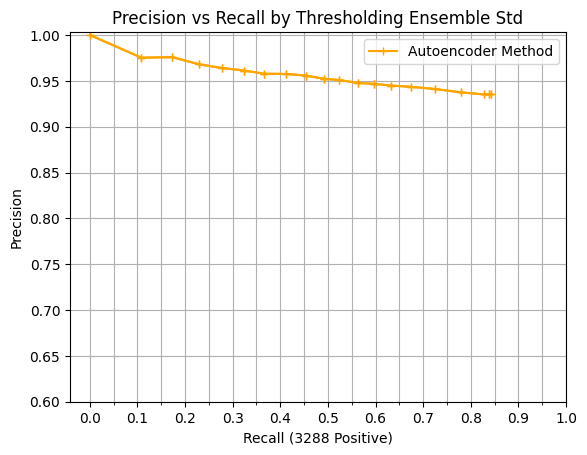

In [ ]:
threshs = sp_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20) # Diff std. dev. thresholds (20 of them in this case)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs] # Portion of instances rejected @ each std threshold
accus = [np.mean((ext_preds==external_Y)[(threshs<=s)]) for s in std_threshs] # Acc @ each std thresh.
tps = [np.sum(((external_Y)*(ext_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ext_preds)*(ext_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.6, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Autoencoder Method'])

In [ ]:
print(accus)

[0.0, 0.5, 0.4738372093023256, 0.4956921309592188, 0.49409681227863045, 0.49305069493050696, 0.4944530357022793, 0.49494787489975944, 0.49523989958793163, 0.49640065362363645, 0.4956647398843931, 0.4954388303411505, 0.4954494914137462, 0.49574293900941463, 0.4954910841800302, 0.4957665065537735, 0.49576926206167116, 0.49581164606376055, 0.4957713263397577, 0.49579251189072726]
